#### Training a computer vision model for Birds Classification

## 0. Importing the libraries

In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2
import torch.nn as nn
import pathlib
import os
import numpy as np
import torchinfo

try:
    from scripts import model_setup
    from scripts import utilities
except ImportError:
    !git clone https://github.com/thomaspierantozzi/PyTorch_Course_by_Daniel_Bourke
    !mv PyTorch_Course_by_Daniel_Bourke/05_PyTorch_Food101/scripts/ .
    !rm -rf ./PyTorch_Course_by_Daniel_Bourke
    from scripts import model_setup


## 1. Downloading the dataset and creating the DataLoaders

In [2]:
IMAGEFOLDER = pathlib.Path('./ImageFolder')
DATASET_TRAIN_FOLDER = IMAGEFOLDER / 'train'
DATASET_TEST_FOLDER = IMAGEFOLDER / 'cv'
MODEL_FOLDER = pathlib.Path('./models')

if not MODEL_FOLDER.exists():
    os.mkdir(MODEL_FOLDER)

#### We will use a different set of weights compared to the default for the ViT_B_16. This set is reported to be more accurate and most importantly uses a different resize. It works with 384x384 pictures; that should help a lot gaining more details from the pictures during training

In [3]:
model_vit = model_setup.ViT_B_16(name='ViT-B-16', SWAG_weights=True)
model_vit.transformers()

ImageClassification(
    crop_size=[384]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [4]:
torchinfo.summary(model_vit,
                  input_size=(32, 3, 384, 384),
                  col_names=["input_size", "output_size", "num_params", "trainable"],
                  row_settings=['var_names']
                  )

Layer (type (var_name))                                           Input Shape               Output Shape              Param #                   Trainable
ViT_B_16 (ViT_B_16)                                               [32, 3, 384, 384]         [32, 1000]                --                        True
├─VisionTransformer (pre_trained_model)                           [32, 3, 384, 384]         [32, 1000]                768                       True
│    └─Conv2d (conv_proj)                                         [32, 3, 384, 384]         [32, 768, 24, 24]         590,592                   True
│    └─Encoder (encoder)                                          [32, 577, 768]            [32, 577, 768]            443,136                   True
│    │    └─Dropout (dropout)                                     [32, 577, 768]            [32, 577, 768]            --                        --
│    │    └─Sequential (layers)                                   [32, 577, 768]            [32, 577, 7

In [5]:
for param in model_vit.parameters():
    param.requires_grad = False

In [6]:
model_vit.pre_trained_model.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [7]:
model_vit.pre_trained_model.heads = nn.Sequential(
    nn.Linear(in_features=768, out_features=332),
)

In [8]:
train_transform = nn.Sequential(
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True), #just to be sure that the order of the dimension is consistent with what needed in pytorch
    v2.RandomRotation(degrees=30),
    v2.RandomPerspective(p=0.3),
    v2.RandomHorizontalFlip(p=0.3),
    model_vit.transformers()
)

cv_transform = nn.Sequential(
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True), #just to be sure that the
    model_vit.transformers()
)

train_transform, cv_transform

(Sequential(
   (0): ToImage()
   (1): ToDtype(scale=True)
   (2): RandomRotation(degrees=[-30.0, 30.0], interpolation=InterpolationMode.NEAREST, expand=False, fill=0)
   (3): RandomPerspective(p=0.3, distortion_scale=0.5, interpolation=InterpolationMode.BILINEAR, fill=0)
   (4): RandomHorizontalFlip(p=0.3)
   (5): ImageClassification(
       crop_size=[384]
       resize_size=[384]
       mean=[0.485, 0.456, 0.406]
       std=[0.229, 0.224, 0.225]
       interpolation=InterpolationMode.BICUBIC
   )
 ),
 Sequential(
   (0): ToImage()
   (1): ToDtype(scale=True)
   (2): ImageClassification(
       crop_size=[384]
       resize_size=[384]
       mean=[0.485, 0.456, 0.406]
       std=[0.229, 0.224, 0.225]
       interpolation=InterpolationMode.BICUBIC
   )
 ))

In [9]:
train_dataset = ImageFolder(
    root=DATASET_TRAIN_FOLDER,
    transform=train_transform
)

cv_dataset = ImageFolder(
    root=DATASET_TEST_FOLDER,
    transform=cv_transform
)

train_dataset, cv_dataset 

(Dataset ImageFolder
     Number of datapoints: 5221
     Root location: ImageFolder/train
     StandardTransform
 Transform: Sequential(
              (0): ToImage()
              (1): ToDtype(scale=True)
              (2): RandomRotation(degrees=[-30.0, 30.0], interpolation=InterpolationMode.NEAREST, expand=False, fill=0)
              (3): RandomPerspective(p=0.3, distortion_scale=0.5, interpolation=InterpolationMode.BILINEAR, fill=0)
              (4): RandomHorizontalFlip(p=0.3)
              (5): ImageClassification(
                  crop_size=[384]
                  resize_size=[384]
                  mean=[0.485, 0.456, 0.406]
                  std=[0.229, 0.224, 0.225]
                  interpolation=InterpolationMode.BICUBIC
              )
            ),
 Dataset ImageFolder
     Number of datapoints: 618
     Root location: ImageFolder/cv
     StandardTransform
 Transform: Sequential(
              (0): ToImage()
              (1): ToDtype(scale=True)
              (2): Im

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2900507..2.780831].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.247537..1.4064751].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.296741..2.8040378].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2577555..1.7843024].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2313662..2.7939727].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1817162..2.3010027].


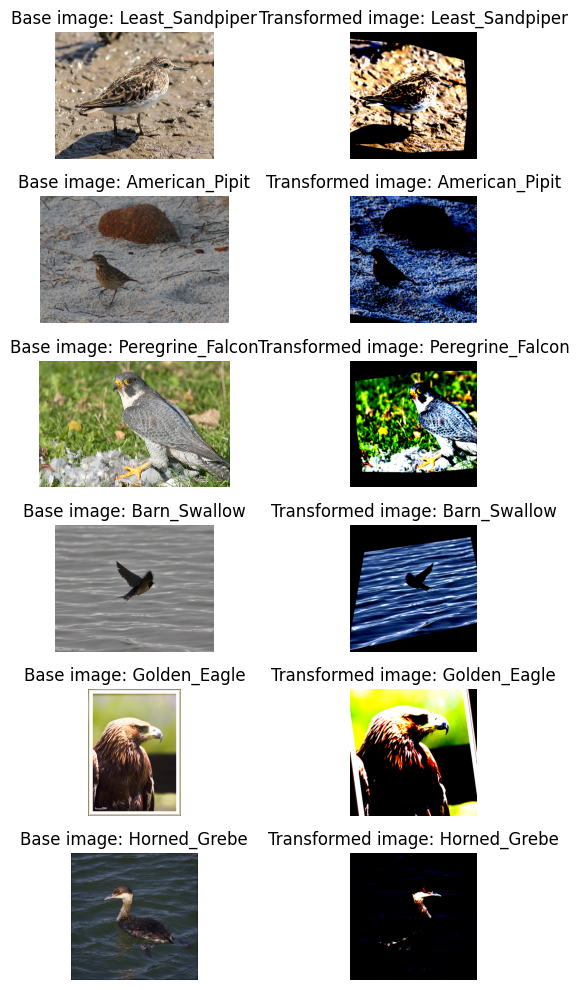

In [10]:
utilities.plot_samples_transformed(
    path=DATASET_TRAIN_FOLDER,
    classes_names=train_dataset.classes,
    transform=train_transform,
)

In [11]:
BATCH_SIZE = 32 #with a minibatch of 32 pictures, torchinfo estimates to have a 10Gb memory usage
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=BATCH_SIZE,
    num_workers=4,
)

cv_loader = torch.utils.data.DataLoader(
    cv_dataset,
    batch_size=BATCH_SIZE,
    num_workers=4,
)

In [12]:
classes_dict = train_dataset.class_to_idx
classes_dict

{'American_Pipit': 0,
 'Arctic_Tern': 1,
 'Barn_Swallow': 2,
 'Black_Tern': 3,
 'Bobolink': 4,
 'Bohemian_Waxwing': 5,
 'Brant': 6,
 'Canada_Goose': 7,
 'Caspian_Tern': 8,
 'Cattle_Egret': 9,
 'Common_Eider': 10,
 'Common_Goldeneye': 11,
 'Common_Loon': 12,
 'Common_Merganser': 13,
 'Common_Murre': 14,
 'Common_Raven': 15,
 'Common_Redpoll': 16,
 'Common_Tern': 17,
 'Dunlin': 18,
 'Eared_Grebe': 19,
 'Eurasian_Wigeon': 20,
 'European_Starling': 21,
 'Gadwall': 22,
 'Glaucous_Gull': 23,
 'Glossy_Ibis': 24,
 'Golden_Eagle': 25,
 'Great_Cormorant': 26,
 'Great_Egret': 27,
 'Greater_Scaup': 28,
 'Harlequin_Duck': 29,
 'Hermit_Thrush': 30,
 'Herring_Gull': 31,
 'Horned_Grebe': 32,
 'Horned_Lark': 33,
 'House_Sparrow': 34,
 'Iceland_Gull': 35,
 'Lapland_Longspur': 36,
 'Laughing_Gull': 37,
 'Least_Sandpiper': 38,
 'Lesser_Yellowlegs': 39,
 'Mallard': 40,
 'Merlin': 41,
 'Mew_Gull': 42,
 'Monk_Parakeet': 43,
 'Mute_Swan': 44,
 'Northern_Bobwhite': 45,
 'Northern_Gannet': 46,
 'Northern_Goshaw

In [13]:
device = 'mps' if torch.mps.is_available() else 'cpu'
model_vit.to(device)

ViT_B_16(
  (pre_trained_model): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (l

In [14]:
MAX_EPOCHS=10
LEARNING_RATE = 1e-2
loss_foo = nn.CrossEntropyLoss(label_smoothing=0.15)
optimizer = torch.optim.Adam(model_vit.parameters(), lr=LEARNING_RATE, weight_decay=3e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer=optimizer,
    eta_min=1e-5,
    T_max=MAX_EPOCHS
)

In [ ]:
from time import time

from tqdm.auto import tqdm
for epoch in range(MAX_EPOCHS):
    print(f'{' EPOCH ' + str(epoch) + ' out of ' + str(MAX_EPOCHS) :*^50}')
    epoch_loss = []
    epoch_acc = []
    epoch_train_time_start = time()
    for batch_index,(train_batch, target_batch) in enumerate(tqdm(train_loader)):
        #passing the batches to the proper device
        train_batch, target_batch = train_batch.to(device), target_batch.to(device)

        batch_train_time_start = time()
        batch_train_loss, batch_train_acc = model_vit.train_step(
            batch_X=train_batch,
            batch_y=target_batch,
            optimizer=optimizer,
            loss_foo=loss_foo,
            device=device
        )
        batch_train_time_end = time()

        #updating the lists keeping track of the losses for the batch
        epoch_loss.append(batch_train_loss)
        epoch_acc.append(batch_train_acc)

        if batch_index % 20 == 0:
            print(model_vit.write_minibatch_results_class(
                batch_index=batch_index,
                batch_quantity=len(train_loader),
                train_loss=epoch_loss,
                batch_loss_train=batch_train_loss,
                train_acc=epoch_acc,
                batch_acc_train=batch_train_acc,
                start_time_iteration=batch_train_time_start,
                end_time_iteration=batch_train_time_end
            ))

    epoch_train_time_end = time()
    print('\tEpoch training closed... Start evaluating the CV set...')
    epoch_cv_loss = []
    epoch_cv_acc = []
    for cv_train_batch, cv_target_batch in cv_loader:
        #passing the batches to the proper device
        cv_train_batch, cv_target_batch = cv_train_batch.to(device), cv_target_batch.to(device)

        batch_cv_loss, batch_cv_acc = model_vit.eval_step(
            batch_test_X=cv_train_batch,
            batch_test_y=cv_target_batch,
            loss_foo=loss_foo,
            device=device
        )

        epoch_cv_loss.append(batch_cv_loss)
        epoch_cv_acc.append(batch_cv_acc)

    #keep track of the history of the training metrics
    model_vit.history_update('train_loss', np.mean(epoch_loss))
    model_vit.history_update('train_acc', np.mean(epoch_acc))
    model_vit.history_update('cv_loss', np.mean(epoch_cv_loss))
    model_vit.history_update('cv_acc', np.mean(epoch_cv_acc))

    print(model_vit.write_epoch_results_class(
        curr_iteration=epoch,
        last_iteration=MAX_EPOCHS,
        train_loss=epoch_loss,
        train_acc=epoch_acc,
        cv_loss=epoch_cv_loss,
        cv_acc=epoch_cv_acc,
        end_time_iteration=epoch_train_time_end,
        start_time_iteration= epoch_train_time_start
    ))
    
    #making a step with the scheduler
    scheduler.step()
     

**************** EPOCH 0 out of 10****************


  0%|          | 0/164 [00:03<?, ?it/s]

Intermediate results for batch 000 out of 164: Train Loss epoch:    5.937 (last:    5.937) | Train Acc. epoch:  3.12% (last:  3.12%) | Elapsed Time: 2.5 sec.
Intermediate results for batch 020 out of 164: Train Loss epoch:    5.300 (last:    3.751) | Train Acc. epoch: 40.33% (last: 46.88%) | Elapsed Time: 1.7 sec.


In [ ]:
import matplotlib.pyplot as plt
metrics = [('train_loss', 'train_acc'),
           ('cv_loss', 'cv_acc')]

fig = plt.figure(figsize=[15, 5], dpi=150)
for index, (loss, acc) in enumerate(metrics):
    fig.add_subplot(1, 2, index + 1)
    plt.plot(
        np.arange(len(model_vit.history[loss])),
        model_vit.history[loss],
        label=loss,
        color='red',
        linewidth = 0.75,
    )
    plt.plot(
        np.arange(len(model_vit.history[loss])),
        model_vit.history[acc],
        label = acc,
        color='black',
        linewidth = 0.75,
        linestyle='--'
    )
    plt.legend()
    plt.title(f'{loss } VS. {acc}')


    plt.grid(linestyle='--', color='gray')

plt.savefig(MODEL_FOLDER / 'loss_acc_history.jpg')

In [ ]:
utilities.save_model(
    path=MODEL_FOLDER,
    model=model_vit,
    optimizer=optimizer,
    epoch_nr=14,
    learning_rate=LEARNING_RATE,
    batch_size=BATCH_SIZE,
    nr_classes=len(classes_dict),
)

In [ ]:
#TODO 1: fare una matrice di confusione per vedere quali sono le classi migliori e peggiori e vedere i correspettivi set di cv quanto siano ok o meno.